In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
tf.random.set_seed(0)

In [55]:
target = tfd.MultivariateNormalDiag([0.])
proposal = tfd.MultivariateNormalDiag([2.])

# kernel = RBF()
kernel = IMQ()

In [56]:
proposal_sample = proposal.sample(1000)

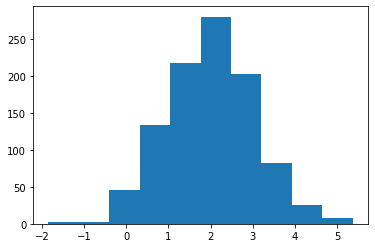

In [57]:
_ = plt.hist(proposal_sample.numpy())

In [58]:
ksd = KSD(target=target, kernel=kernel)
ksd_val = ksd(proposal_sample, tf.identity(proposal_sample)).numpy()
ksd_val

2.7912824

In [73]:
def run_ksd_experiment(nrep, target, proposal, kernel):
    """compute KSD and repeat for nrep times"""
    ksd = KSD(target=target, kernel=kernel)
    
    nsamples_list = list(range(10, 100, 10)) + list(range(100, 1100, 100))
    ksd_list = []
    ksd_df = pd.DataFrame(columns=["n", "ksd", "seed"])
    for n in nsamples_list:
        print(f"n = {n}")
        ksd_n_list = []
        for seed in range(nrep):
            proposal_sample = proposal.sample(n)
            ksd_val = ksd(proposal_sample, tf.identity(proposal_sample)).numpy()
            ksd_n_list.append(ksd_val)
            ksd_df.loc[len(ksd_df)] = [n, ksd_val, seed]
    return ksd_df

In [60]:
nrep = 10

ksd_df = run_ksd_experiment(nrep, target, proposal, kernel)

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


(0.0, 3.682068687856197)

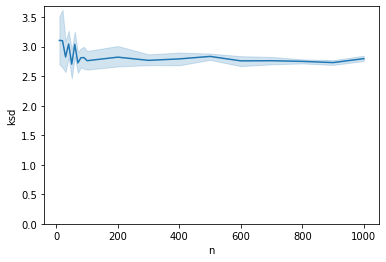

In [61]:
sns.lineplot(data=ksd_df, x="n", y="ksd")
plt.ylim((0, None))

# Mixture of gaussian experiment

In [75]:
def create_mixture_gaussian(dim, delta):
    e1 = tf.eye(dim)[:, 0]
    mix_gauss = tfd.Mixture(
      cat=tfd.Categorical(probs=[0.5, 0.5]),
      components=[
        tfd.MultivariateNormalDiag(-delta * e1),
        tfd.MultivariateNormalDiag(delta * e1)
    ])
    return mix_gauss
    

In [76]:
delta = 1.5
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)

proposal_mean = - delta * tf.eye(dim)[:, 0]
proposal = tfd.MultivariateNormalDiag(proposal_mean)

(array([  9.,  47., 136., 178., 141., 161., 170., 117.,  32.,   9.]),
 array([-4.4571652 , -3.5498328 , -2.6425004 , -1.7351681 , -0.82783574,
         0.07949662,  0.986829  ,  1.8941613 ,  2.8014936 ,  3.708826  ,
         4.6161585 ], dtype=float32),
 <BarContainer object of 10 artists>)

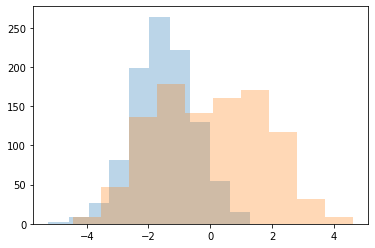

In [78]:
plt.hist(proposal.sample(1000).numpy()[:, 0], alpha=0.3)
plt.hist(target.sample(1000).numpy()[:, 0], alpha=0.3)

In [79]:
ksd_df = run_ksd_experiment(nrep, target, proposal, kernel)

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


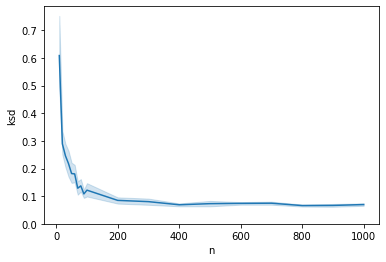

In [80]:
sns.lineplot(data=ksd_df, x="n", y="ksd")
_ = plt.ylim((0, None))

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


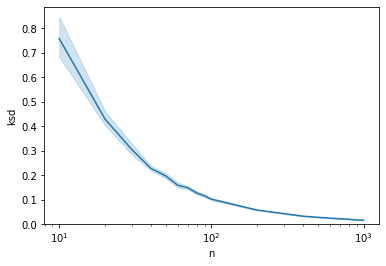

In [83]:
# with RBF
ksd_df = run_ksd_experiment(nrep, target, proposal, RBF())

sns.lineplot(data=ksd_df, x="n", y="ksd")
_ = plt.ylim((0, None))
plt.xscale("log")